# MAC0417/5768 - Visão e Processamento de Imagens

**Aluno**: Lucas Martinuzzo Batista

## EP3.1 Segmentação do objeto
Segmentação do objeto de interesse: O objetivo desta etapa é segmentar o  objeto do fundo, produzindo uma imagem binária: 0 para o fundo e 1 para o objeto. Dois tipos de segmentação serão usados: manual, para geração do ground-truth, e automática usando algum algoritmo de sua escolha. Exemplo de ground-truth:

O ground-truth deve ser gerado para pelo menos 15% das amostras de cada classe. 

### Link do Repositório:
https://github.com/LucasMartinuzzo/Visao-Computacional-2020-2

### Google Drive (Apenas Imagens)

https://drive.google.com/drive/folders/1CSLHaRzTfbsbN09WyKYIs3qf_qiBkQGT?usp=sharing

### Tabela Global Sumária da Base Aumentada

| Atributo | Valor |
| :- | -: |
| Número de Classes | 10 |
| Número de Imagens | 5400 |
| Tamanho da Base| 523 mb |
| Dimensão | 720 x 960 |

#### Tabela Detalhada Por Classe da Base Aumentada
| Classe | Qtd. Objetos | Qtd. Fundos | Qtd. luminação | Qtd. Repetições | Qtd. de Operações| Total de Amostras | 
| :-: | :-: | :-: | :-: | :-: | :-: | :-: |
| Caneca | 3 | 3 | 4 | 3 | 5 | 540
| Caneta | 3 | 3 | 4 | 3 | 5 | 540
| Chave | 3 | 3 | 4 | 3 | 5 | 540
| Creme Dental | 3 | 3 | 4 | 3 | 5 | 540
| Faca | 3 | 3 | 4 | 3 | 5 | 540
| Fio Dental | 3 | 3 | 4 | 3 | 5 | 540
| Meia | 3 | 3 | 4 | 3 | 5 | 540
| Perfume | 3 | 3 | 4 | 3 | 5 | 540
| Pilha | 3 | 3 | 4 | 3 | 5 | 540
| Shampoo | 3 | 3 | 4 | 3 | 5 | 540

### Funções Auxiliares

In [1]:
base_directory = "../Imagens/ManualSegmentatedGrayDataset/Image"
mask_directory = "../Imagens/ManualSegmentatedGrayDataset/Mask"
N_SAMPLE_BY_CLASS = 4

In [2]:
import os
import cv2
import matplotlib.pyplot as plt
from matplotlib.colors import NoNorm
import numpy as np
import scipy.misc
import scipy.ndimage
import skimage.filters
import sklearn.metrics
from PIL import Image
import PIL.ImageOps   
# Turn on interactive mode. Turn off with plt.ioff()
plt.ion()
%matplotlib inline

In [3]:
def selectRandImages(image_dir,n_sample_by_class = 4):
    folders = os.listdir(image_dir)
    rand_images = {}
    for folder in folders:
        list_images = []
        files = os.listdir(os.path.join(image_dir,folder))
        for sample in range(n_sample_by_class):
            list_images.append(files[np.random.randint(len(files),size=1)[0]])
            list_images.append(files[np.random.randint(len(files),size=1)[0]])
            list_images.append(files[np.random.randint(len(files),size=1)[0]])
            list_images.append(files[np.random.randint(len(files),size=1)[0]])
        rand_images[folder] = list_images
    return rand_images

In [4]:
def plotSample(image_dir,sample_images_dict,columns=4,gray_mode=False,function=None,prefix=None):
    rows = len(sample_images_dict)
    fig, axes = plt.subplots(rows,columns,figsize=(18,24),constrained_layout=True)
    axes.flatten()
    for i,title in enumerate(sample_images_dict):
        class_dir = os.path.join(image_dir,title)
        for j in range(columns):
            if prefix is None:
                filename = sample_images_dict[title][j]
            else:
                filename = prefix + '_' + sample_images_dict[title][j]
            image=cv2.imread(os.path.join(class_dir,filename),0)
            if function is not None:
                image = function(image)
            if(gray_mode):
                axes[i][j].imshow(image,cmap='gray',norm=NoNorm())
            else:
                axes[i][j].imshow(image)
            axes[i,0].set_ylabel(title,rotation=90,size='large',color="red")
            axes[i][j].set_yticks([])
            axes[i][j].set_xticks([])
    fig.show()
    return

#### Amostra das imagens

In [5]:
rand_sample = selectRandImages(base_directory,N_SAMPLE_BY_CLASS)

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


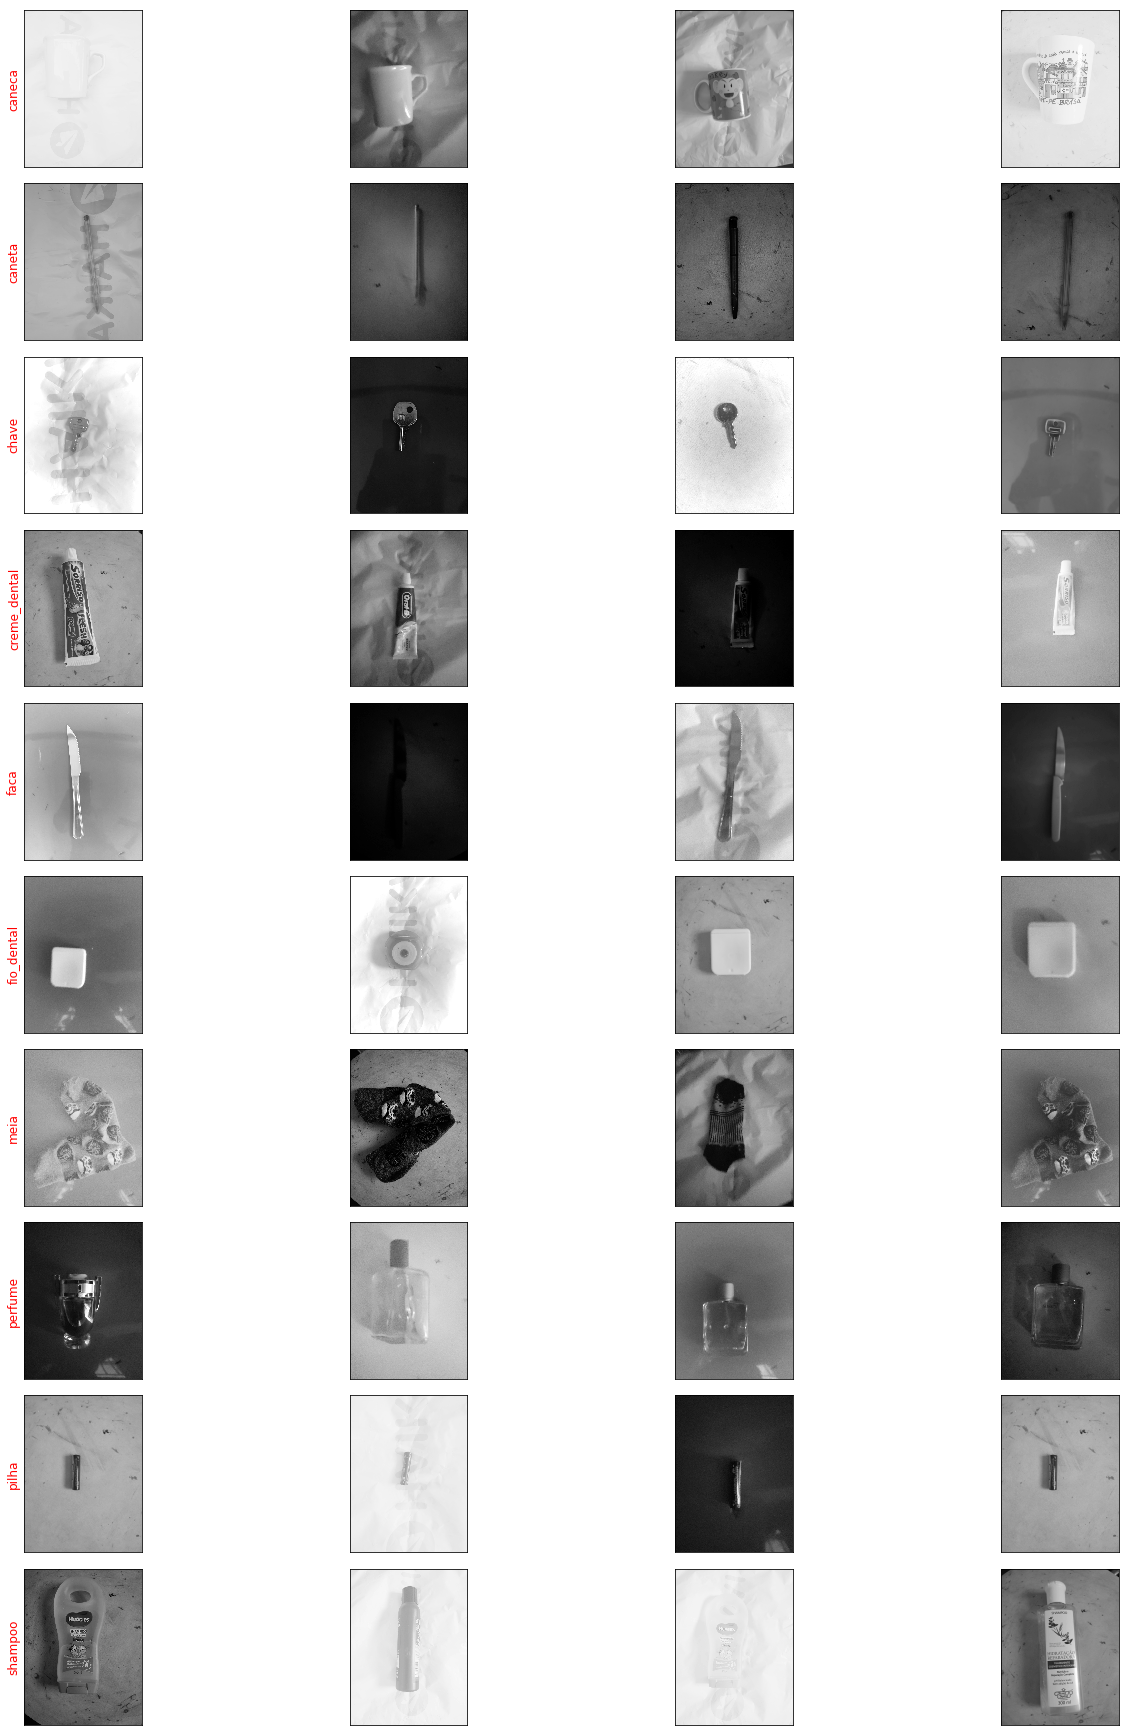

In [6]:
plotSample(base_directory,rand_sample,N_SAMPLE_BY_CLASS,True)

### Segmentação Manual

A segmentação manual foi realizada utilizando a ferramenta de seleção livre do Gimp:

<img src="./gimp.PNG" />

As imagens de cada classe foram escolhidas aleatoriamente com a restrição de metade delas serem images fotografadas durante o dia e metade durante a noite.

#### Amostra de imagens segmentadas manualmente:

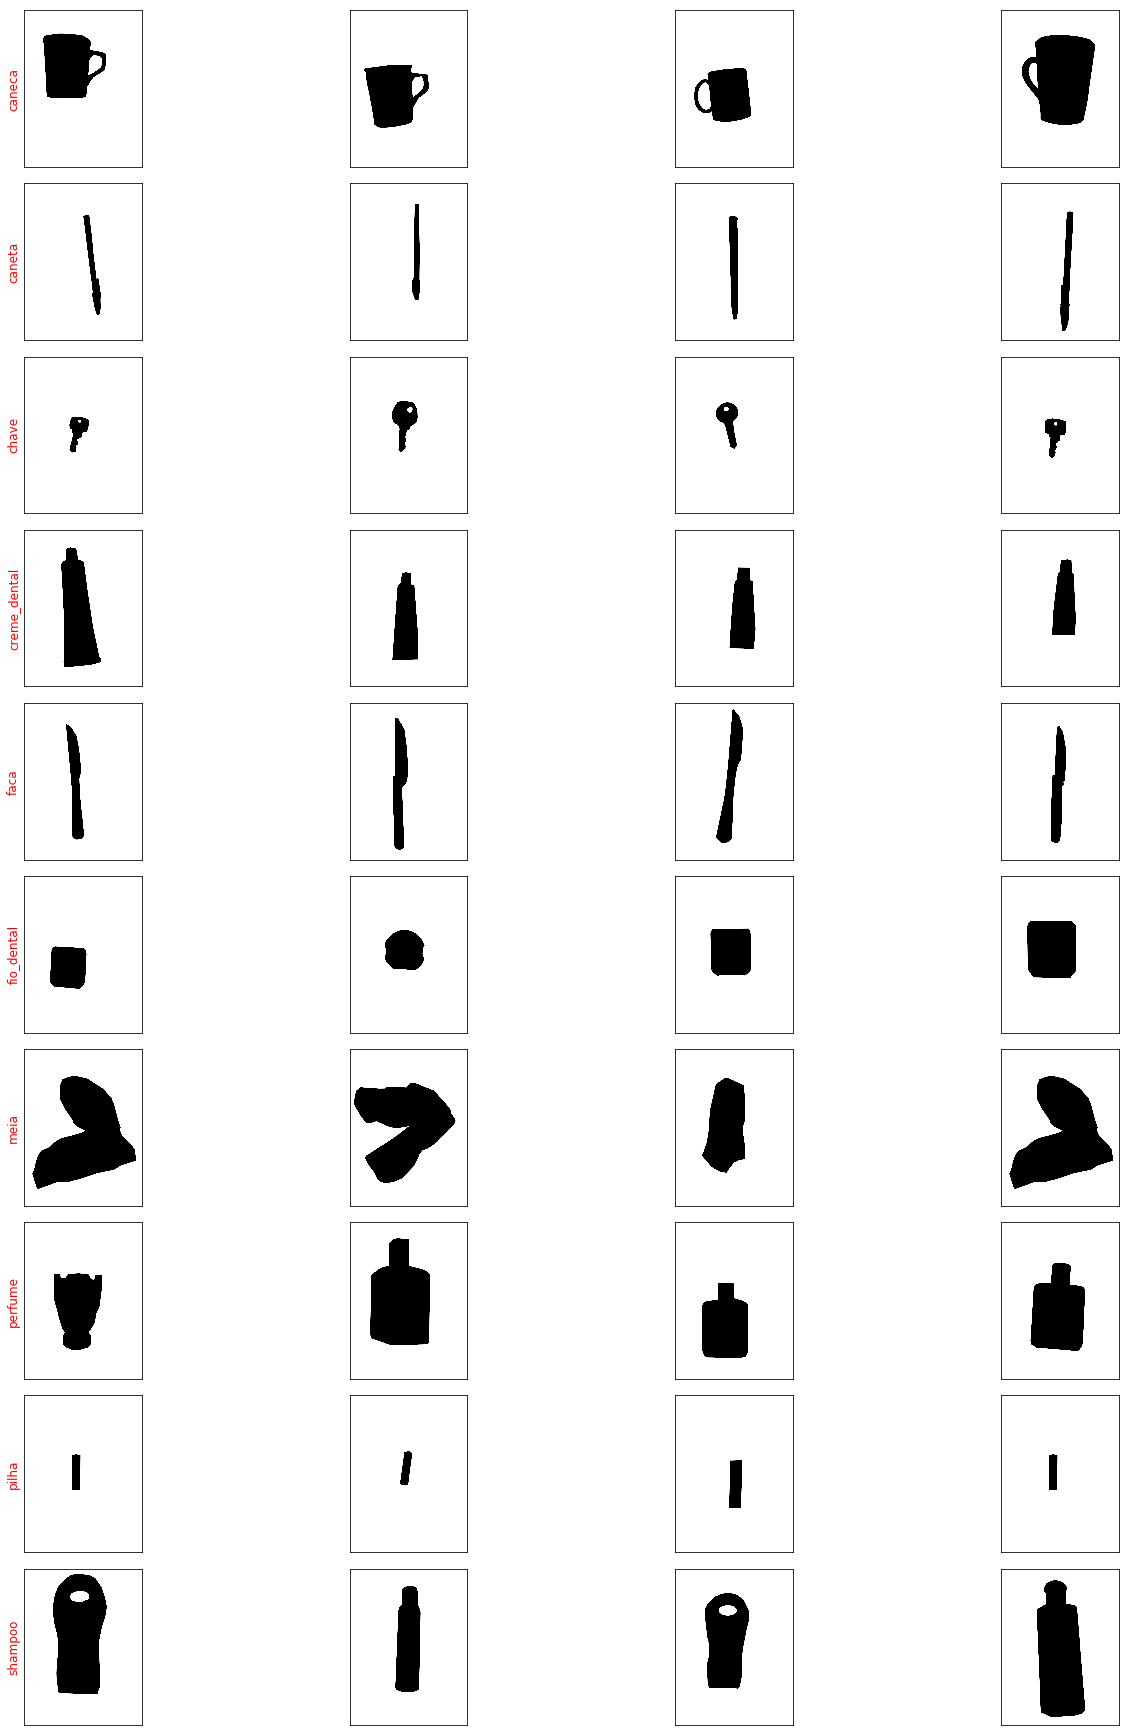

In [7]:
plotSample(mask_directory,rand_sample,N_SAMPLE_BY_CLASS,True)

### Segmentação Automática

Como mencionado em aula, a segmentação automática depende muito do contraste entre a imagem e o fundo.
Por essa razão, métodos mais simples de segmentação, como por seleção de threshold de nível de cinza (local ou global) não funcionaram. (https://scikit-image.org/docs/stable/auto_examples/applications/plot_thresholding.html)

Métodos por seleção de borda ou região, como indicados a seguir também foram falhos. (https://scikit-image.org/docs/0.12.x/auto_examples/xx_applications/plot_coins_segmentation.html)

Cheguei a tentar separar métodos diferentes para cada classe, porém a diferença de iluminação e fundo também influenciam bastante, então para alcançar um resultado satisfatório eu precisaria construir uma combinação de filtros diferentes para subconjunto de imagens com características visuais semelhantes, o que tira o próposito de ser automático.

Finalmente, decidi uilizar uma rede neural com o propósito de segmentação, treinada com as imagens segmentadas manualmente para obter um resultado satisfatório, mas ainda imperfeito, como será mostrado em exemplos. Apesar dos métodos citados acima não terem sido usados para segmentar, alguns serão utilizados como pós-processamento das máscaras criadas na rede, para diminuir as imperfeições.

#### O modelo

O modelo utilizado se chama U-net e o algoritmo utilizado foi uma implementação que utiliza o Keras, API do TensorFlow. A maior desvantagem do método é o tempo levado para treinar a rede e a necessidade da utilização de placa de vídeo dedicada, para diminuir este tempo.

O código não foi implementado por mim, e pode ser encontrado no link a seguir: https://github.com/zhixuhao/unet

<center>
<figure>
    <img src="https://github.com/zhixuhao/unet/blob/master/img/u-net-architecture.png?raw=true">
    <figcaption>U-NET</figcaption>
</figure>
</center>

#### Parâmetros

Inicialmente, rodei a rede neural nas imagens em sua resolução padrão que adotei no trabalho (720x960), porém a grande quantidade de pixels demandava memória demais da placa de vídeo, por isso reduzi o tamanho das imagens em 3, obtendo resolução final de 240x320. Isso permitiu que a rede rodasse e aprendesse mais rapidamente. Além disso, classes diferentes tiveram complexidades diferentes ao rodar.
Os parâmetros que modifiquei foram: batch_size, epochs, e steps_per_epoch.

Iniciei com batch_size = 1, epochs = 4 e steps_per_epoch = 1000, porém nenhuma das classes obteve resultado satisfatório. Ao aumentar o batch_size para 2, três das classes já alcançaram bons resultados. Fui modificando os parâmetros até achar resultados que julguei satisfatórios. Os parâmetros finais foram os seguintes:

caneca, caneta, faca = 2, 1000, 4
creme_dental, meia = 4,1000,4
chave, pilha: 5,1000,5
shampoo: 6,1000,5

#### Tabela de Parâmetros Utiizados por Classe
| Classe | batch_size | epochs | steps_per_epoch |
| :-: | :-: | :-: | :-: |
| Caneca | 2 | 4 | 1000 |
| Caneta | 2 | 4 | 1000 |
| Chave | 5 | 5 | 1000 |
| Creme Dental | 4 | 4 | 1000 |
| Faca | 2 | 4 | 1000 | 
| Fio Dental | 6 | 3 | 2000 |
| Meia | 4 | 4 | 1000 |
| Perfume | 6 | 3 | 2000 |
| Pilha | 5 | 5 | 1000 | 
| Shampoo | 6 | 5 | 1000 |


#### Execução

Para rodar o algoritmo, os arquivos devem estar configurados de maneira correta. Todas as imagens devem ter o tamanho passado nos arquivos auxiliares do Unet, neste caso 240 x 320 px. Além disso, como o algoritmo não está configurado para multiclasse, cada classe foi treinada separadamente. Por isso, os arquivos foram revidividos e organizados de maneira que o programa os reconheça.

Dentro da pasta de cada classe, existem as pastas:
- **train**: subdivida em **image** e **label**, onde ficam as imagens em nível de cinza e máscaras binárias, respectivamente;
- **test**: pasta que armazena as imagens em nível de cinza que o modelo treinado irá processar;
- **results**: pasta que receberá as imagens processadas.

Todas as imagens devem ser enumeradas em sequência crescente a partir de 0 e as imagens de treino e suas respectivas máscaras devem ter números iguais.

Os arquivos dos modelos são salvos na pasta **models** com o nome unet_{classe}.hdf5 e pesa aproximada 365 MB cada um.

In [8]:
from model import *
from data import *
import os

A função a seguir recebe o nome da classe processada e inicia o treino da rede neural que gera um modelo de saída no formado .hdf5.

In [9]:
model_images_directory = "../Imagens/UnetDataset/"

In [10]:
def modelGenerator(classe,local,batch_size,epochs,steps_per_epoch):
    path = os.path.join(local,classe,'train')
    print('Iniciando classe: ',classe)
    print(path)
    data_gen_args = dict(rotation_range=0.2,
                    width_shift_range=0.05,
                    height_shift_range=0.05,
                    shear_range=0.05,
                    zoom_range=0.05,
                    horizontal_flip=True,
                    fill_mode='nearest')
    myGene = trainGenerator(6,path,'image','label',data_gen_args,save_to_dir = None)
    model = unet()
    model_checkpoint = ModelCheckpoint('.models/unet_'+classe+'.hdf5', monitor='loss',verbose=1, save_best_only=True)
    model.fit_generator(myGene,steps_per_epoch=2000,epochs=3,callbacks=[model_checkpoint])

In [11]:
entradas = [('caneca',2,4,1000),
            ('caneta',2,4,1000),
            ('chave',5,5,1000),
            ('creme_dental',4,4,1000),
            ('faca',2,4,1000),
            ('fio_dental',6,3,2000),
            ('meia',4,4,1000),
            ('perfume',6,3,2000),
            ('pilha',5,5,1000),
            ('shampoo',6,5,1000)
]

Como já treinei os modelos, manterei a linha abaixo comentada. Caso deseje retreinar, as linhas abaixos devem ser descomentadas. 

In [12]:
#for (classe,batch_size,epoch,steps_per_epoch) in entradas:
#    modelGenerator(classe,model_images_directory,batch_size,epoch,steps_per_epoch)

Uma vez treinandos os modelos, eles devem processar o restante das imagens.

In [13]:
def generateResults(classe, local):
    test_path = os.path.join(local,classe,'test')
    results_path = os.path.join(local,classe,'results')
    print(classe)
    print("------------------------------------------------------------------------------------")
    files_count = len(os.listdir(test_path))
    testGene = testGenerator(test_path,num_image=files_count)
    model = unet()
    model.load_weights('models/unet_'+classe+'.hdf5')
    results = model.predict_generator(testGene,files_count,verbose=1)
    saveResult(results_path,results)

Como já executei os modelos, manterei a linha abaixo comentada. Caso deseje reprocessar, as linhas abaixo devem ser descomentadas. 

In [14]:
# for (classe,_,_,_) in entradas:
#     generateResults(classe,model_images_directory)

### Pós-processamento.

In [91]:
import os
import cv2
import matplotlib.pyplot as plt
import imutils
from matplotlib.colors import NoNorm
import numpy as np
import scipy.misc
import scipy.ndimage
import skimage.filters
import sklearn.metrics
from PIL import Image
import skimage.io as io
import PIL.ImageOps
from scipy import ndimage as ndi
from skimage import morphology
import pandas as pd
# Turn on interactive mode. Turn off with plt.ioff()
plt.ion()
%matplotlib inline

Algumas imagens apareceram com ruídos. As proximas etapas são tentativas de diminuir tais ruídos.
<center>
<figure>
    <img src="./chave_ruidosa.png">
    <figcaption>Exemplo: Segmentação de chave apareceu com formas estranhas na imagem.
</figcaption>
</figure>
</center>

In [16]:
def binarize(image):
    image[image <= 180] = 0
    image[image > 180] = 255
    return image

In [17]:
def eraseNoise(image,size):
    inter = cv2.morphologyEx(image, cv2.MORPH_CLOSE, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (size, size)))
    cnts, _ = cv2.findContours(inter, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    cnt = max(cnts, key=cv2.contourArea)
    out = np.zeros(image.shape, np.uint8)
    cv2.drawContours(out, [cnt], -1, 255, cv2.FILLED)
    out = cv2.bitwise_and(image, out)
    return out

In [18]:
def fillSmallHoles(image,size_kernel_1,size_kernel_2):
    kernel = np.ones((size_kernel_1,size_kernel_1),np.uint8)
    closing = cv2.morphologyEx(image, cv2.MORPH_CLOSE, kernel)
    kernel = np.ones((size_kernel_2,size_kernel_2),np.uint8)
    opening = cv2.morphologyEx(closing, cv2.MORPH_OPEN, kernel)
    return closing

In [125]:
entradas = [('caneca',[(eraseNoise,25),(fillSmallHoles,10,2)]),
            ('caneta',[(eraseNoise,25)]),
            ('chave',[(eraseNoise,5)]),
            ('creme_dental',[(eraseNoise,25),(fillSmallHoles,25,2)]),
            ('faca',[(eraseNoise,2)]),
            ('fio_dental',[(eraseNoise,25),(fillSmallHoles,50,48)]),
            ('meia',[(eraseNoise,1),(fillSmallHoles,10,10)]),
            ('perfume',[(eraseNoise,5),(fillSmallHoles,30,2)]),
            ('pilha',[(eraseNoise,2),(fillSmallHoles,50,50)]),
            ('shampoo',[(eraseNoise,5),(fillSmallHoles,18,18)])
]

In [122]:
def applyTransformations(classe,local,funcoes):
    results_path = os.path.join(local,classe,'results')
    post_results_path = os.path.join(local,classe,'results_pos')
    if not os.path.exists(post_results_path):
        os.makedirs(post_results_path)
    files = os.listdir(results_path)
    for file in files:
        image = cv2.imread(os.path.join(results_path,file),0)
        image = binarize(image)
        image = np.invert(image)
        transformation,arg = funcoes[0]
        image = transformation(image,arg)
        try:
            transformation,arg1,arg2 = funcoes[1]
            image = transformation(image,arg1,arg2)
        except Exception as e:
            pass
        finally:
            image = np.invert(image)
        io.imsave(os.path.join(post_results_path,file),image)

In [126]:
 for classe,funcoes in entradas:
    print(classe)
    applyTransformations(classe,model_images_directory,funcoes)

meia


#### Amostras de imagens segmentadas pelo algoritmo antes do pós-processamento

In [112]:
def selectRandImages2(image_dir,n_sample_by_class = 4):
    folders = os.listdir(image_dir)
    rand_images = {}
    for folder in folders:
        list_images = []
        files = os.listdir(os.path.join(image_dir,folder,'test'))
        for sample in range(n_sample_by_class):
            list_images.append(files[np.random.randint(len(files),size=1)[0]])
            list_images.append(files[np.random.randint(len(files),size=1)[0]])
            list_images.append(files[np.random.randint(len(files),size=1)[0]])
            list_images.append(files[np.random.randint(len(files),size=1)[0]])
        rand_images[folder] = list_images
    return rand_images

def plotSample2(image_dir,sample_images_dict,columns=4,posProcessed=False,function = None):
    rows = len(sample_images_dict)
    fig, axes = plt.subplots(rows,columns,figsize=(18,24),constrained_layout=True)
    axes.flatten()
    for i,title in enumerate(sample_images_dict):
        class_dir = os.path.join(image_dir,title)
        for j in range(columns):
            filename = sample_images_dict[title][j]
            filename = filename[:-4] + '_predict_resized.png'
            path = ''
            if posProcessed:
                path = os.path.join(class_dir,'results_pos',filename)
            else:
                path = os.path.join(class_dir,'results',filename)
            image=cv2.imread(path,0)
            if function is not None:
                image = function(image)
            axes[i][j].imshow(image,cmap='gray',norm=NoNorm())
            axes[i,0].set_ylabel(title,rotation=90,size='large',color="red")
            axes[i][j].set_yticks([])
            axes[i][j].set_xticks([])
    fig.show()
    return

In [42]:
rand_sample2 = selectRandImages2(model_images_directory,N_SAMPLE_BY_CLASS)

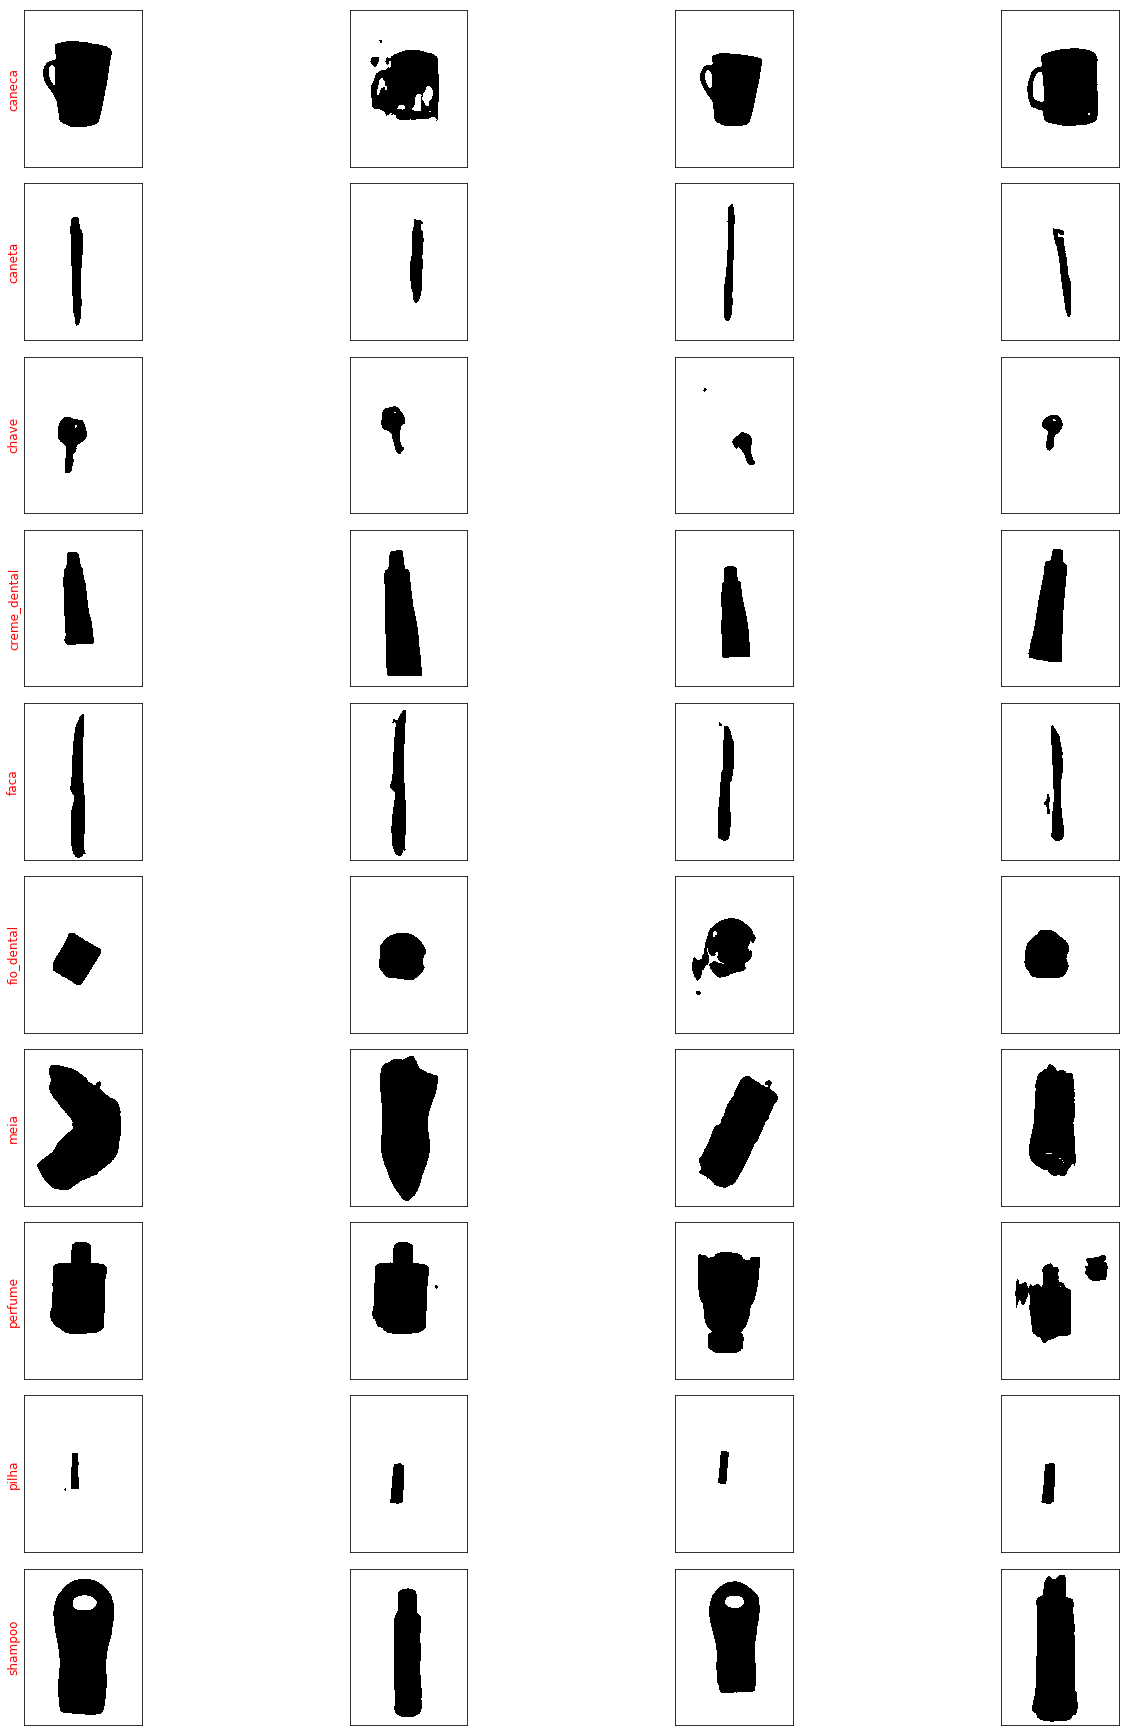

In [117]:
plotSample2(model_images_directory,rand_sample2,N_SAMPLE_BY_CLASS,False)

#### Após o pós-processamento

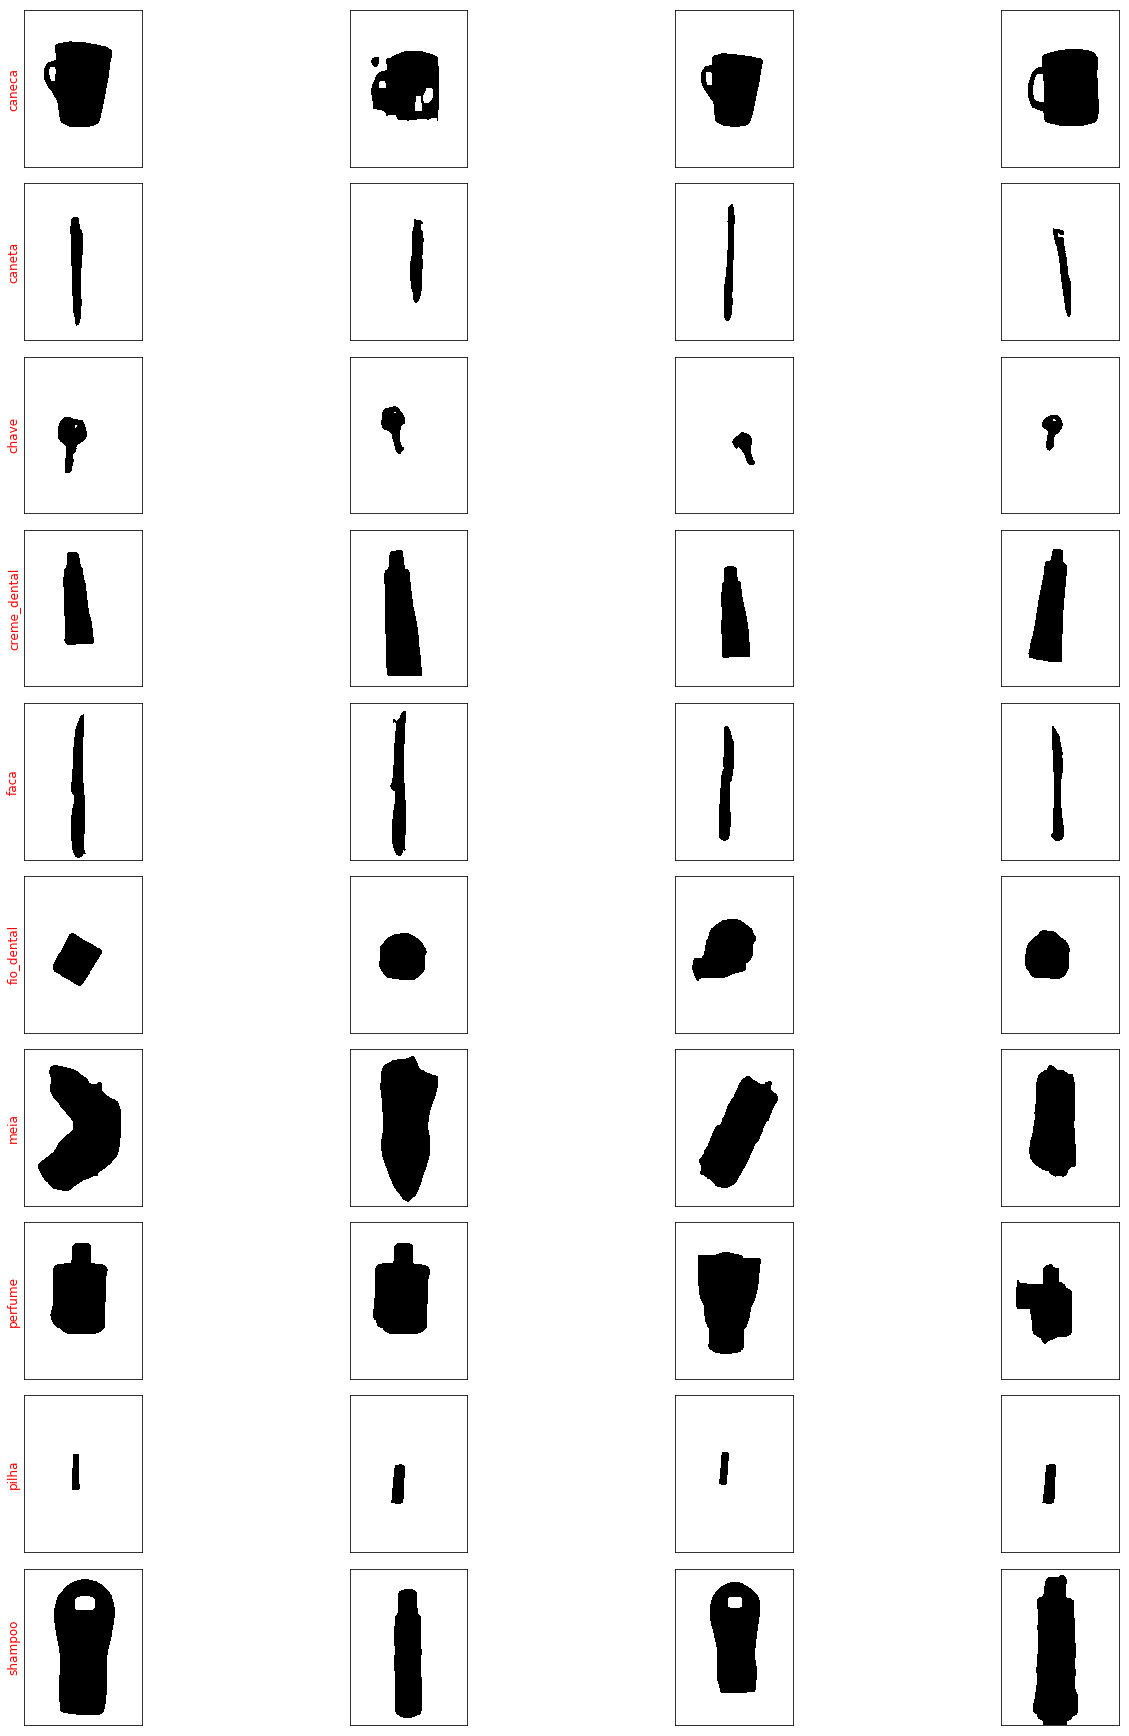

In [127]:
plotSample2(model_images_directory,rand_sample2,N_SAMPLE_BY_CLASS,True)

### Extração de Bounding Box

Nesta seção, os Bounding Boxes das imagens segmentadas manualmente e pelo algoritmo serão geradas e salvas nos diretórios abaixo.

In [130]:
automatic_seg_bb = 'BoundingBoxes/AutomaticSeg'
manual_seg_bb = 'BoundingBoxes/ManualSeg'

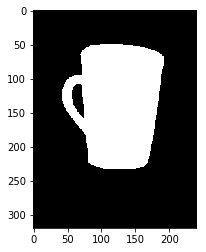

In [67]:
image=cv2.imread('caneca.png',0)
image = np.invert(image)
plt.imshow(image,cmap='gray',norm=NoNorm())

In [68]:
cnts, _ = cv2.findContours(image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
cnt = cnt = max(cnts, key=cv2.contourArea)
x,y,w,h = cv2.boundingRect(cnt)
# cv2.rectangle(img,(x,y),(x+w,y+h),(0,255,0),2)

In [76]:
teste = cv2.boundingRect(cnt)

In [78]:
bb = []

In [88]:
bb.append(teste)

In [89]:
bb

[(42, 50, 149, 184),
 (42, 50, 149, 184),
 (42, 50, 149, 184),
 (42, 50, 149, 184)]

In [92]:
pd.DataFrame(bb,columns=['x','y','w','h'])

,x,y,w,h
0,42,50,149,184
1,42,50,149,184
2,42,50,149,184
3,42,50,149,184


In [69]:
print(x,y,w,h)

42 50 149 184


In [108]:
image_bb = cv2.rectangle(image,(x,y),(x+w,y+h),127,2)

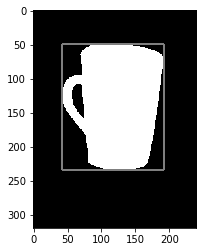

In [109]:
plt.imshow(image_bb,cmap='gray',norm=NoNorm())

In [119]:
def createBoundingBox(image):
    image = np.invert(image)
    cnts, _ = cv2.findContours(image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    boxes = []
    for c in cnts:
        (x, y, w, h) = cv2.boundingRect(c)
        boxes.append([x,y, x+w,y+h])

    boxes = np.asarray(boxes)
    left, top = np.min(boxes, axis=0)[:2]
    right, bottom = np.max(boxes, axis=0)[2:]
    return (left,top,right-left,bottom-top)

In [120]:
def applyBoundingBox(image):
    x,y,w,h = createBoundingBox(image)
    image_bb = cv2.rectangle(image,(x,y),(x+w,y+h),127,2)
    return image_bb

In [103]:
def extractAllBoundingBoxes(classe,prefix_local,posfix_local,boundingBox_local):
    mask_path = os.path.join(prefix_local,classe,posfix_local)
    bbs = []
    if not os.path.exists(boundingBox_local):
        os.makedirs(boundingBox_local)
    files = os.listdir(mask_path)
    for file in files:
        path = os.path.join(mask_path,file)
        image = cv2.imread(path,0)
        x, y, w, h = createBoundingBox(image)
        bbs.append((path,x,y,w,h))
    df = pd.DataFrame(bbs,columns=['file','x','y','w','h'])
    df.to_csv(os.path.join(boundingBox_local,classe+'.csv'),index=False)

In [106]:
classes = ['caneca',
    'caneta',
    'chave',
    'creme_dental',
    'faca',
    'fio_dental',
    'meia',
    'perfume',
    'pilha',
    'shampoo',
]

In [129]:
# for classe in classes:
#     print(classe)
#     extractAllBoundingBoxes(classe,model_images_directory,'results_pos',automatic_seg_bb)
#     extractAllBoundingBoxes(classe,model_images_directory,'train/label',manual_seg_bb)

caneca


KeyboardInterrupt: 

#### Imagens com sua respectiva Bounding Box

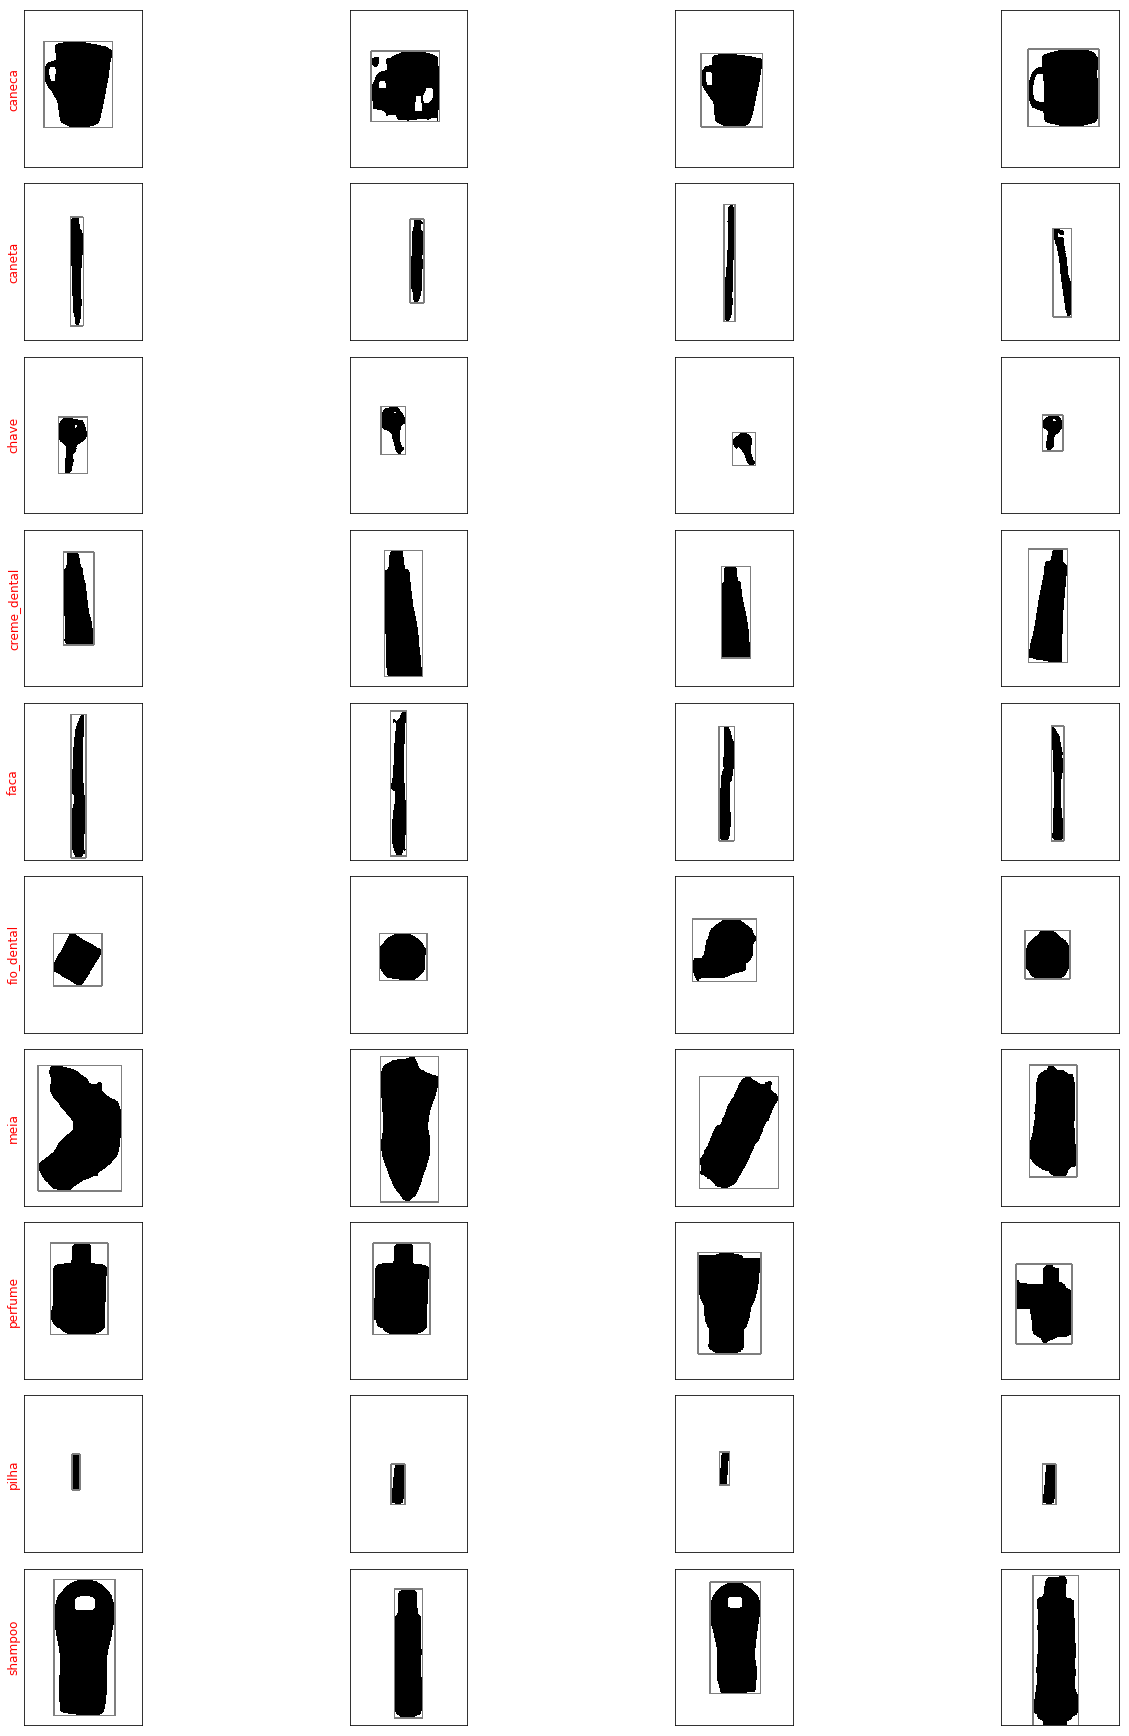

In [128]:
plotSample2(model_images_directory,rand_sample2,N_SAMPLE_BY_CLASS,True,applyBoundingBox)